In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
import torch

# Convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # Input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # Forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # Put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # Drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg


In [2]:
# Load dataset
dataset = pd.read_csv('../data/pollution.csv', header=0, index_col=0)

dataset

,pollution,dew,temp,press,wnd_dir,wnd_spd,snow,rain
date,,,,,,,,
2010-01-02 00:00:00,129.0,-16,-4.0,1020.0,SE,1.79,0,0
2010-01-02 01:00:00,148.0,-15,-4.0,1020.0,SE,2.68,0,0
2010-01-02 02:00:00,159.0,-11,-5.0,1021.0,SE,3.57,0,0
2010-01-02 03:00:00,181.0,-7,-5.0,1022.0,SE,5.36,1,0
2010-01-02 04:00:00,138.0,-7,-5.0,1022.0,SE,6.25,2,0
...,...,...,...,...,...,...,...,...
2014-12-31 19:00:00,8.0,-23,-2.0,1034.0,NW,231.97,0,0
2014-12-31 20:00:00,10.0,-22,-3.0,1034.0,NW,237.78,0,0
2014-12-31 21:00:00,10.0,-22,-3.0,1034.0,NW,242.70,0,0


In [3]:
values = dataset.values

# Integer encode direction
encoder = LabelEncoder()
values[:, 4] = encoder.fit_transform(values[:, 4])

# Ensure all data is float
values = values.astype('float32')

# Normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

scaled

array([[0.12977867, 0.35294122, 0.24590163, ..., 0.00229001, 0.        ,
        0.        ],
       [0.14889336, 0.36764708, 0.24590163, ..., 0.00381099, 0.        ,
        0.        ],
       [0.15995975, 0.4264706 , 0.22950819, ..., 0.00533197, 0.        ,
        0.        ],
       ...,
       [0.01006036, 0.2647059 , 0.26229507, ..., 0.41399646, 0.        ,
        0.        ],
       [0.00804829, 0.2647059 , 0.24590163, ..., 0.4208665 , 0.        ,
        0.        ],
       [0.01207243, 0.2794118 , 0.26229507, ..., 0.42621556, 0.        ,
        0.        ]], dtype=float32)

In [4]:
# Frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)

reframed

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var1(t),var2(t),var3(t),var4(t),var5(t),var6(t),var7(t),var8(t)
1,0.129779,0.352941,0.245902,0.527273,0.666667,0.002290,0.000000,0.0,0.148893,0.367647,0.245902,0.527273,0.666667,0.003811,0.000000,0.0
2,0.148893,0.367647,0.245902,0.527273,0.666667,0.003811,0.000000,0.0,0.159960,0.426471,0.229508,0.545454,0.666667,0.005332,0.000000,0.0
3,0.159960,0.426471,0.229508,0.545454,0.666667,0.005332,0.000000,0.0,0.182093,0.485294,0.229508,0.563637,0.666667,0.008391,0.037037,0.0
4,0.182093,0.485294,0.229508,0.563637,0.666667,0.008391,0.037037,0.0,0.138833,0.485294,0.229508,0.563637,0.666667,0.009912,0.074074,0.0
5,0.138833,0.485294,0.229508,0.563637,0.666667,0.009912,0.074074,0.0,0.109658,0.485294,0.213115,0.563637,0.666667,0.011433,0.111111,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43795,0.010060,0.264706,0.278689,0.763638,0.333333,0.385730,0.000000,0.0,0.008048,0.250000,0.278689,0.781818,0.333333,0.395659,0.000000,0.0
43796,0.008048,0.250000,0.278689,0.781818,0.333333,0.395659,0.000000,0.0,0.010060,0.264706,0.262295,0.781818,0.333333,0.405588,0.000000,0.0
43797,0.010060,0.264706,0.262295,0.781818,0.333333,0.405588,0.000000,0.0,0.010060,0.264706,0.262295,0.781818,0.333333,0.413996,0.000000,0.0
43798,0.010060,0.264706,0.262295,0.781818,0.333333,0.413996,0.000000,0.0,0.008048,0.264706,0.245902,0.781818,0.333333,0.420866,0.000000,0.0


In [5]:
# Drop columns we don't want to predict
reframed.drop(reframed.columns[[9, 10, 11, 12, 13, 14, 15]], axis=1, inplace=True)
reframed

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var1(t)
1,0.129779,0.352941,0.245902,0.527273,0.666667,0.002290,0.000000,0.0,0.148893
2,0.148893,0.367647,0.245902,0.527273,0.666667,0.003811,0.000000,0.0,0.159960
3,0.159960,0.426471,0.229508,0.545454,0.666667,0.005332,0.000000,0.0,0.182093
4,0.182093,0.485294,0.229508,0.563637,0.666667,0.008391,0.037037,0.0,0.138833
5,0.138833,0.485294,0.229508,0.563637,0.666667,0.009912,0.074074,0.0,0.109658
...,...,...,...,...,...,...,...,...,...
43795,0.010060,0.264706,0.278689,0.763638,0.333333,0.385730,0.000000,0.0,0.008048
43796,0.008048,0.250000,0.278689,0.781818,0.333333,0.395659,0.000000,0.0,0.010060
43797,0.010060,0.264706,0.262295,0.781818,0.333333,0.405588,0.000000,0.0,0.010060
43798,0.010060,0.264706,0.262295,0.781818,0.333333,0.413996,0.000000,0.0,0.008048


In [6]:
# Split into train and test sets
values = reframed.values
n_train_hours = 365 * 24
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
train


array([[0.12977867, 0.35294122, 0.24590163, ..., 0.        , 0.        ,
        0.14889336],
       [0.14889336, 0.36764708, 0.24590163, ..., 0.        , 0.        ,
        0.15995975],
       [0.15995975, 0.4264706 , 0.22950819, ..., 0.        , 0.        ,
        0.18209255],
       ...,
       [0.        , 0.32352942, 0.22950819, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.32352942, 0.16393442, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.33823532, 0.1967213 , ..., 0.        , 0.        ,
        0.0362173 ]], dtype=float32)

In [7]:

# Split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

# Reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

# Convert data to PyTorch tensors
train_X = torch.tensor(train_X, dtype=torch.float32)
train_y = torch.tensor(train_y, dtype=torch.float32).view(-1, 1)
test_X = torch.tensor(test_X, dtype=torch.float32)
test_y = torch.tensor(test_y, dtype=torch.float32).view(-1, 1)

print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

torch.Size([8760, 1, 8]) torch.Size([8760, 1]) torch.Size([35039, 1, 8]) torch.Size([35039, 1])


In [8]:
import torch.nn as nn

# Define the LSTM model
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x):
        _, (hn, _) = self.lstm(x)
        out = self.fc(hn[-1])
        return out

input_dim = train_X.shape[2]
hidden_dim = 50
output_dim = 1

model = LSTMModel(input_dim, hidden_dim, output_dim)


In [9]:
# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


Epoch 1/50, Loss: 0.0072
Epoch 2/50, Loss: 0.0031
Epoch 3/50, Loss: 0.0011
Epoch 4/50, Loss: 0.0010
Epoch 5/50, Loss: 0.0010
Epoch 6/50, Loss: 0.0010
Epoch 7/50, Loss: 0.0010
Epoch 8/50, Loss: 0.0010
Epoch 9/50, Loss: 0.0010
Epoch 10/50, Loss: 0.0010
Epoch 11/50, Loss: 0.0010
Epoch 12/50, Loss: 0.0010
Epoch 13/50, Loss: 0.0010
Epoch 14/50, Loss: 0.0010
Epoch 15/50, Loss: 0.0010
Epoch 16/50, Loss: 0.0009
Epoch 17/50, Loss: 0.0010
Epoch 18/50, Loss: 0.0009
Epoch 19/50, Loss: 0.0010
Epoch 20/50, Loss: 0.0009
Epoch 21/50, Loss: 0.0010
Epoch 22/50, Loss: 0.0010
Epoch 23/50, Loss: 0.0009
Epoch 24/50, Loss: 0.0009
Epoch 25/50, Loss: 0.0009
Epoch 26/50, Loss: 0.0009
Epoch 27/50, Loss: 0.0009
Epoch 28/50, Loss: 0.0009
Epoch 29/50, Loss: 0.0009
Epoch 30/50, Loss: 0.0009
Epoch 31/50, Loss: 0.0009
Epoch 32/50, Loss: 0.0010
Epoch 33/50, Loss: 0.0009
Epoch 34/50, Loss: 0.0009
Epoch 35/50, Loss: 0.0009
Epoch 36/50, Loss: 0.0009
Epoch 37/50, Loss: 0.0009
Epoch 38/50, Loss: 0.0009
Epoch 39/50, Loss: 0.

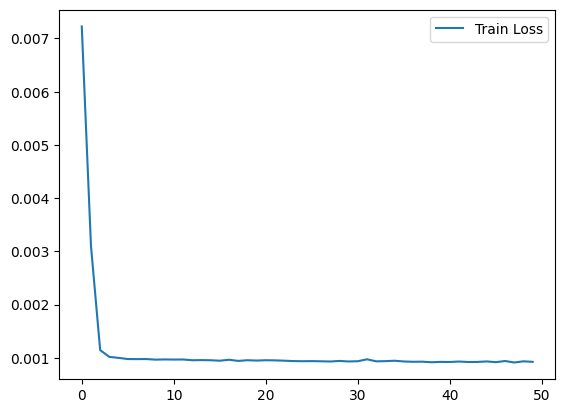

In [10]:
# Train the model
epochs = 50
batch_size = 72
train_loss = []

for epoch in range(epochs):
    model.train()
    permutation = torch.randperm(train_X.size(0))
    epoch_loss = 0

    for i in range(0, train_X.size(0), batch_size):
        indices = permutation[i:i + batch_size]
        batch_X, batch_y = train_X[indices], train_y[indices]

        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()

    train_loss.append(epoch_loss / (train_X.size(0) // batch_size))
    print(f"Epoch {epoch + 1}/{epochs}, Loss: {train_loss[-1]:.4f}")

# Plot training loss
import matplotlib.pyplot as plt
plt.plot(train_loss, label='Train Loss')
plt.legend()
plt.show()


In [11]:
from sklearn.metrics import mean_squared_error
from math import sqrt

# Evaluate the model
model.eval()
with torch.no_grad():
    yhat = model(test_X)
    yhat = yhat.numpy()
    test_X = test_X.numpy().reshape((test_X.shape[0], test_X.shape[2]))

    # Invert scaling for forecast
    inv_yhat = np.concatenate((yhat, test_X[:, 1:]), axis=1)
    inv_yhat = scaler.inverse_transform(inv_yhat)
    inv_yhat = inv_yhat[:, 0]

    # Invert scaling for actual
    test_y = test_y.numpy()
    inv_y = np.concatenate((test_y, test_X[:, 1:]), axis=1)
    inv_y = scaler.inverse_transform(inv_y)
    inv_y = inv_y[:, 0]

    # Calculate RMSE
    rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
    print(f'Test RMSE: {rmse:.3f}')


Test RMSE: 26.811
